# Install and Import modules

In [1]:
# !tar xfvz /kaggle/input/ultralytics-for-offline-install/archive.tar.gz
# !pip install --no-index --find-links=./packages ultralytics
# !rm -rf ./packages

In [2]:
# !cp -r '/kaggle/input/hengck-czii-cryo-et-01/wheel_file' '/kaggle/working/'
# !pip install /kaggle/working/wheel_file/asciitree-0.3.3/asciitree-0.3.3
# !pip install --no-index --find-links=/kaggle/working/wheel_file zarr

In [3]:
import zarr
from ultralytics import YOLO
from tqdm import tqdm
import glob, os
import torch

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

In [5]:
DATA_KAGGLE_DIR = '../../raw'

MODE='local'

if MODE=='local':
    valid_dir =f'{DATA_KAGGLE_DIR}/train'
    valid_id = ['TS_5_4', ]
    
if MODE=='submit':
    valid_dir =f'{DATA_KAGGLE_DIR}/test' 
    valid_id = glob.glob(f'{valid_dir}/static/ExperimentRuns/*')
    valid_id = [f.split('/')[-1] for f in valid_id]
    
print('valid_id:',len(valid_id), valid_id)

valid_id: 1 ['TS_5_4']


We use a recursive function in this notebook, and we change the settings to explore the graph deep enough.

In [6]:
import sys
sys.setrecursionlimit(10000)

In [7]:
import warnings
warnings.simplefilter('ignore')
np.warnings = warnings

# Prepare trained YOLO model

In [8]:
model = YOLO("../../runs/detect/padding2_/weights/best.pt")

In [9]:
#change by @minfuka
# runs[:5]
# sp = len(valid_id)//2
runs = valid_id

In [10]:
#add by @minfuka
# runs2 = valid_id[sp:]
# runs2[:5]

In [11]:
#add by @minfuka
assert torch.cuda.device_count() == 1

In [12]:
#Information about labels

In [13]:
particle_names = ['apo-ferritin', 'beta-amylase', 'beta-galactosidase', 'ribosome', 'thyroglobulin', 'virus-like-particle']

In [14]:
p2i_dict = {
        'apo-ferritin': 0,
        'beta-amylase': 1,
        'beta-galactosidase': 2,
        'ribosome': 3,
        'thyroglobulin': 4,
        'virus-like-particle': 5
    }

i2p = {v:k for k, v in p2i_dict.items()}

In [15]:
particle_radius = {
        'apo-ferritin': 60,
        'beta-amylase': 65,
        'beta-galactosidase': 90,
        'ribosome': 150,
        'thyroglobulin': 130,
        'virus-like-particle': 135,
    }

# define Main process class
There are many variables and functions going back and forth. We can easily manage variables by defining classes.

In [16]:
class PredAggForYOLO:
    def __init__(self, first_conf=0.2, final_conf=0.3, conf_coef=0.75):
        self.first_conf = first_conf # threshold of confidence yolo
        self.final_conf = final_conf # final threshold score (not be used in version 14)
        self.conf_coef = conf_coef # if found many points, give bonus
        self.particle_confs = [0.5, 0.0, 0.2, 0.5, 0.2, 0.5] # be strict to easy labels 
        # self.particle_confs = [0.25, 0.0, 0.1, 0.25, 0.1, 0.25] # be strict to easy labels 
        # self.particle_confs = [0.75, 0.0, 0.3, 0.75, 0.3, 0.75] # be strict to easy labels 

    def convert_to_8bit(self, x):
        lower, upper = np.percentile(x, (0.5, 99.5))
        x = np.clip(x, lower, upper)
        x = (x - x.min()) / (x.max() - x.min() + 1e-12) * 255
        return x.round().astype("uint8")

    # depth first search.
    # aggregate the coordinates and confidence scores of connected graphs.
    def dfs(self, v):
        self.passed[v] = True
        self.conf_sum += self.pdf.iloc[v].confidence
        self.cx += self.pdf.iloc[v].x
        self.cy += self.pdf.iloc[v].y
        self.cz += self.pdf.iloc[v].z
        self.nv += 1
        for next_v in self.adjacency_list[v]:
            if (self.passed[next_v]): continue
            self.dfs(next_v)

    # main routine.
    # change by @minfuka
    # def make_predict_yolo(self, r, model):
    def make_predict_yolo(self, r, model, device_no):
        vol = zarr.open(f'{valid_dir}/static/ExperimentRuns/{r}/VoxelSpacing10.000/denoised.zarr', mode='r')
        vol = vol[0]
        vol2 = self.convert_to_8bit(vol)
        n_imgs = vol2.shape[0]
    
        df = pd.DataFrame()
    
        pts = []
        confs = []
        xs = []
        ys = []
        zs = []
        
        for i in range(n_imgs):
            # Unfortunately the image size needs to be a multiple of 32.
            tmp_img = np.zeros((630, 630))
            tmp_img[:] = vol2[i]
    
            inp_arr = np.stack([tmp_img]*3,axis=-1)
            # 元画像のサイズを確認
            h, w = inp_arr.shape[:2]

            # 必要なパディング量を計算 (左右と上下に均等に追加)
            padding = (640 - max(h, w)) // 2  # 10ピクセルのパディング

            # パディングを適用
            padded_image = cv2.copyMakeBorder(
                inp_arr,
                top=padding,
                bottom=padding,
                left=padding,
                right=padding,
                borderType=cv2.BORDER_CONSTANT,
                value=(0, 0, 0)  # 黒背景（RGB画像の場合）
            )

            # change by @minfuka
            # res = model.predict(inp_arr, save=False, imgsz=640, conf=self.first_conf, device="0", batch=1, verbose=False)
            res = model.predict(inp_arr, save=False, imgsz=640, conf=self.first_conf, device=device_no, batch=1, verbose=False)
            for j, result in enumerate(res):
                boxes = result.boxes # Boxes object for bounding box outputs    
                for k in range(len(boxes.cls)):
                    ptype = i2p[boxes.cls.cpu().numpy()[k]] # particle type
                    conf = boxes.conf.cpu().numpy()[k] # confidence score
                    # YOLO can infer (start_x, end_x, start_y, end_y)
                    xc = (boxes.xyxy[k,0] + boxes.xyxy[k,2]) / 2.0 * 10 - padding
                    yc = (boxes.xyxy[k,1] + boxes.xyxy[k,3]) / 2.0 * 10 - padding
                    zc = i * 10 + 5
    
                    pts.append(ptype)
                    confs.append(conf)
                    xs.append(xc.cpu().numpy())
                    ys.append(yc.cpu().numpy())
                    zs.append(zc)           
                
        df['particle_type'] = pts
        df['confidence'] = confs
        df['x'] = xs
        df['y'] = ys
        df['z'] = zs

        # df includes overall canditate of CIRCLE. 
        df = df.sort_values(['particle_type', 'z'], ascending=[True, True])
    
        agg_df = []

        # infer center of sphere each particle types
        for pidx, p in enumerate(particle_names):
            if p == 'beta-amylase':
                continue
            pdf = df[df['particle_type']==p].reset_index(drop=True)
            self.pdf = pdf
            p_rad = particle_radius[p]

            # The distance between the x and y coordinates of adjacent slices is expected to be very small.
            xy_tol = p_rad / 16.0
            xy_tol_p2 = xy_tol ** 2

            # define the graph
            self.adjacency_list = [[] for _ in range(len(pdf))]
            # which already passed in dfs
            self.passed = [False for _ in range(len(pdf))]

            # Connect two points when they are close enough
            for i in range(len(pdf)):
                x1 = pdf['x'].iloc[i]
                y1 = pdf['y'].iloc[i]
                z1 = pdf['z'].iloc[i]
                for j in range(i+1, len(pdf), 1):
                    x2 = pdf['x'].iloc[j]
                    y2 = pdf['y'].iloc[j]
                    z2 = pdf['z'].iloc[j]
                    # Can be pruned. thanks to min fuka (@minfuka)
                    if abs(z1-z2)>20:
                        break
    
                    dist_p2 = (x1-x2)**2 + (y1-y2)**2
                    if dist_p2<xy_tol_p2 and dist_p2+(z1-z2)**2 < p_rad**2 and abs(z1-z2)<=20:
                        self.adjacency_list[i].append(j)
                        self.adjacency_list[j].append(i)

            rdf = pd.DataFrame()
            cxs = []
            cys = []
            czs = []

            # Perform DFS on all points and find the center of the sphere from the average of the coordinates
            for i in range(len(pdf)):
                self.conf_sum = 0
                self.nv = 0
                self.cx = 0
                self.cy = 0
                self.cz = 0
                if not self.passed[i]:
                    self.dfs(i)

                # Different confidence for different particle types
                if self.nv>=2 and self.conf_sum / (self.nv**self.conf_coef) > self.particle_confs[pidx]:
                    cxs.append(self.cx / self.nv)
                    cys.append(self.cy / self.nv)
                    czs.append(self.cz / self.nv)

            rdf['experiment'] = [r] * len(cxs)
            rdf['particle_type'] = [p] * len(cys)
            rdf['x'] = cxs
            rdf['y'] = cys
            rdf['z'] = czs

            agg_df.append(rdf)

       
        return pd.concat(agg_df, axis=0)

In [17]:
# instance main class
agent = PredAggForYOLO(first_conf=0.15, final_conf=0.2, conf_coef=0.5) # final_conf is not used after version 14
# subs = []

In [18]:
# subs = []

In [19]:
import time
#add by @minfuka
from concurrent.futures import ProcessPoolExecutor #add by @minfuka

# main loop of inference

In [20]:
#add by @minfuka
def inference(runs, model, device_no):
    subs = []
    for r in tqdm(runs, total=len(runs)):
        df = agent.make_predict_yolo(r, model, device_no)
        subs.append(df)
    
    return subs

In [21]:
%%time
# tick = time.time()
#change by @minfuka
subs = []
for r in tqdm(runs, total=len(runs)):
    df = agent.make_predict_yolo(r, model, "0")
    subs.append(df)
# with ProcessPoolExecutor(max_workers=2) as executor:
#     results = list(executor.map(inference, (runs1, runs2), (model, model), ("0", "1")))
# tock = time.time()

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:12<00:00, 12.38s/it]

CPU times: user 11.8 s, sys: 1.58 s, total: 13.4 s
Wall time: 12.4 s


In [22]:
# print(f'estimated predict time is {(tock-tick)/3*500:.4f} seconds')

In [23]:
valid_id

['TS_5_4']

In [24]:
#submission = pd.concat(subs).reset_index(drop=True)
#change by @minfuka
# submission1 = pd.concat(results[1])
# if len(valid_id) == 1:
#     submission = submission1.copy()
# else:
#     submission0 = pd.concat(results[0])
#     submission = pd.concat([submission0, submission1]).reset_index(drop=True)
submission = pd.concat(subs).reset_index(drop=True)
submission.insert(0, 'id', range(len(submission)))

In [25]:
submission.to_csv("submission.csv", index=False)
submission.head()

,id,experiment,particle_type,x,y,z
0,0,TS_5_4,apo-ferritin,5871.719293,5121.800456,85.000000
1,1,TS_5_4,apo-ferritin,5468.516113,1516.680542,90.000000
2,2,TS_5_4,apo-ferritin,5740.401367,5099.844849,90.000000
3,3,TS_5_4,apo-ferritin,5711.852894,4992.111639,125.909091
4,4,TS_5_4,apo-ferritin,5736.321289,5105.258545,120.000000


# Scoring

https://www.kaggle.com/code/hengck23/3d-unet-using-2d-image-encoder/notebook

In [26]:
if MODE=='local':
    import sys
    sys.path.append('hengck')
    
    from czii_helper import *
    from dataset import *
    from model2 import *
    import numpy as np
    from scipy.optimize import linear_sum_assignment

['TS_5_4']
 TS_5_4 virus-like-particle
         particle_type    P   T  hit  miss   fp  precision    recall  \
0         apo-ferritin   95  46   39     7   56   0.410526  0.847826   
1         beta-amylase    0  10    0    10    0   0.000000  0.000000   
2   beta-galactosidase  109  12    7     5  102   0.064220  0.583333   
3             ribosome   84  31   29     2   55   0.345238  0.935484   
4        thyroglobulin  133  30   23     7  110   0.172932  0.766667   
5  virus-like-particle   20  11   11     0    9   0.550000  1.000000   

    f-beta4  weight  
0  0.797834       1  
1  0.000000       0  
2  0.395349       2  
3  0.850000       1  
4  0.637847       2  
5  0.954082       1  
lb_score: 0.6669009362388713

TS_5_4 apo-ferritin
	 num truth   : 46
	 num predict : 95
	 num hit  : 42
	 num fp   : 53
	 num miss : 4
TS_5_4 beta-amylase
	 num truth   : 10
	 num predict : 0
	 num hit  : 0
	 num fp   : 0
	 num miss : 10
TS_5_4 beta-galactosidase
	 num truth   : 12
	 num predict : 109

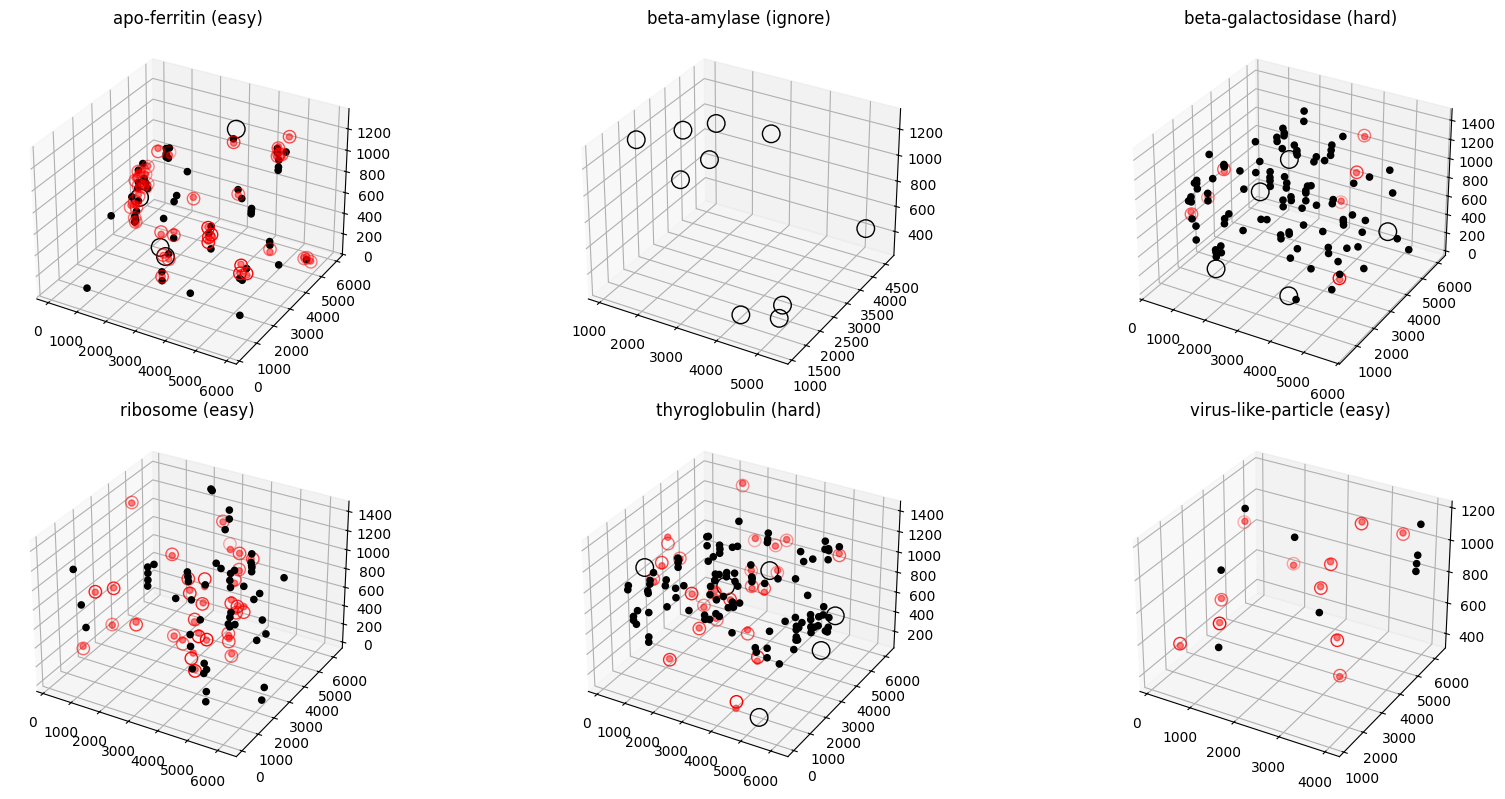

In [27]:
def do_one_eval(truth, predict, threshold):
    P=len(predict)
    T=len(truth)

    if P==0:
        hit=[[],[]]
        miss=np.arange(T).tolist()
        fp=[]
        metric = [P,T,len(hit[0]),len(miss),len(fp)]
        return hit, fp, miss, metric

    if T==0:
        hit=[[],[]]
        fp=np.arange(P).tolist()
        miss=[]
        metric = [P,T,len(hit[0]),len(miss),len(fp)]
        return hit, fp, miss, metric

    #---
    distance = predict.reshape(P,1,3)-truth.reshape(1,T,3)
    distance = distance**2
    distance = distance.sum(axis=2)
    distance = np.sqrt(distance)
    p_index, t_index = linear_sum_assignment(distance)

    valid = distance[p_index, t_index] <= threshold
    p_index = p_index[valid]
    t_index = t_index[valid]
    hit = [p_index.tolist(), t_index.tolist()]
    miss = np.arange(T)
    miss = miss[~np.isin(miss,t_index)].tolist()
    fp = np.arange(P)
    fp = fp[~np.isin(fp,p_index)].tolist()

    metric = [P,T,len(hit[0]),len(miss),len(fp)] #for lb metric F-beta copmutation
    return hit, fp, miss, metric


def compute_lb(submit_df, overlay_dir):
    valid_id = list(submit_df['experiment'].unique())
    print(valid_id)

    eval_df = []
    for id in valid_id:
        truth = read_one_truth(id, overlay_dir) #=f'{valid_dir}/overlay/ExperimentRuns')
        id_df = submit_df[submit_df['experiment'] == id]
        for p in PARTICLE:
            p = dotdict(p)
            print('\r', id, p.name, end='', flush=True)
            xyz_truth = truth[p.name]
            xyz_predict = id_df[id_df['particle_type'] == p.name][['x', 'y', 'z']].values
            hit, fp, miss, metric = do_one_eval(xyz_truth, xyz_predict, p.radius* 0.5)
            eval_df.append(dotdict(
                id=id, particle_type=p.name,
                P=metric[0], T=metric[1], hit=metric[2], miss=metric[3], fp=metric[4],
            ))
    print('')
    eval_df = pd.DataFrame(eval_df)
    gb = eval_df.groupby('particle_type').agg('sum').drop(columns=['id'])
    gb.loc[:, 'precision'] = gb['hit'] / gb['P']
    gb.loc[:, 'precision'] = gb['precision'].fillna(0)
    gb.loc[:, 'recall'] = gb['hit'] / gb['T']
    gb.loc[:, 'recall'] = gb['recall'].fillna(0)
    gb.loc[:, 'f-beta4'] = 17 * gb['precision'] * gb['recall'] / (16 * gb['precision'] + gb['recall'])
    gb.loc[:, 'f-beta4'] = gb['f-beta4'].fillna(0)

    gb = gb.sort_values('particle_type').reset_index(drop=False)
    # https://www.kaggle.com/competitions/czii-cryo-et-object-identification/discussion/544895
    gb.loc[:, 'weight'] = [1, 0, 2, 1, 2, 1]
    lb_score = (gb['f-beta4'] * gb['weight']).sum() / gb['weight'].sum()
    return gb, lb_score


#debug
if 1:
    if MODE=='local':
    #if 1:
        submit_df=submission.copy()
        gb, lb_score = compute_lb(submit_df, f'{valid_dir}/overlay/ExperimentRuns')
        print(gb)
        print('lb_score:',lb_score)
        print('')


        #show one ----------------------------------
        fig = plt.figure(figsize=(18, 8))

        id = valid_id[0]
        truth = read_one_truth(id,overlay_dir=f'{valid_dir}/overlay/ExperimentRuns')

        submit_df = submit_df[submit_df['experiment']==id]
        for p in PARTICLE:
            p = dotdict(p)
            xyz_truth = truth[p.name]
            xyz_predict = submit_df[submit_df['particle_type']==p.name][['x','y','z']].values
            hit, fp, miss, _ = do_one_eval(xyz_truth, xyz_predict, p.radius)
            print(id, p.name)
            print('\t num truth   :',len(xyz_truth) )
            print('\t num predict :',len(xyz_predict) )
            print('\t num hit  :',len(hit[0]) )
            print('\t num fp   :',len(fp) )
            print('\t num miss :',len(miss) )

            ax = fig.add_subplot(2, 3, p.label, projection='3d')
            if hit[0]:
                pt = xyz_predict[hit[0]]
                ax.scatter(pt[:, 0], pt[:, 1], pt[:, 2], alpha=0.5, color='r')
                pt = xyz_truth[hit[1]]
                ax.scatter(pt[:,0], pt[:,1], pt[:,2], s=80, facecolors='none', edgecolors='r')
            if fp:
                pt = xyz_predict[fp]
                ax.scatter(pt[:, 0], pt[:, 1], pt[:, 2], alpha=1, color='k')
            if miss:
                pt = xyz_truth[miss]
                ax.scatter(pt[:, 0], pt[:, 1], pt[:, 2], s=160, alpha=1, facecolors='none', edgecolors='k')

            ax.set_title(f'{p.name} ({p.difficulty})')

        plt.tight_layout()
        plt.show()
        
        #--- 
        zz=0